In [1]:
import numpy as np
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
import polars as pl
from operator import sub
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}'
})

In [2]:
pd_target = 0.99
pex_target = 0.01

def get_reward(pd, pex):
    if pd <= pd_target and pex >= pex_target:
        a = pd/pd_target
        b = (1-pex) / (1-pex_target)
        return 0.5 * a * a * b * b


    if pd > pd_target and pex >= pex_target:
        a = 1.0
        b = (1-pex) / (1-pex_target)
        return 0.5 * a * a * b * b


    if pd <= pd_target and pex < pex_target:
        a = pd/pd_target
        b = 1.0
        return 0.5 * a * a * b * b


    if pd > pd_target and pex < pex_target:
        a = (pd - pd_target) / (1-pd_target)
        b = (pex_target-pex) / pex_target
        return 0.5 + 0.5 * a * b
    

    return 0

In [3]:
df = pl.DataFrame()
n = 175

for i in np.arange(30, 300, 5):
    for q in np.arange(0, 300, 5):
        for r in range(50):
            try:
                df_curr = pl.read_csv(f'../res/v49/kpi_rdf_n{n}_i{i}_q{q}_r{r}.csv')
                reward = get_reward(df_curr['pd'][0],df_curr['pe500'][0])
                df = pl.concat([df, pl.DataFrame({
                    'i': i,
                    'q': q,
                    'reward': reward
                })])
            except:
                pass


In [4]:
aoi_target = 736 # ms

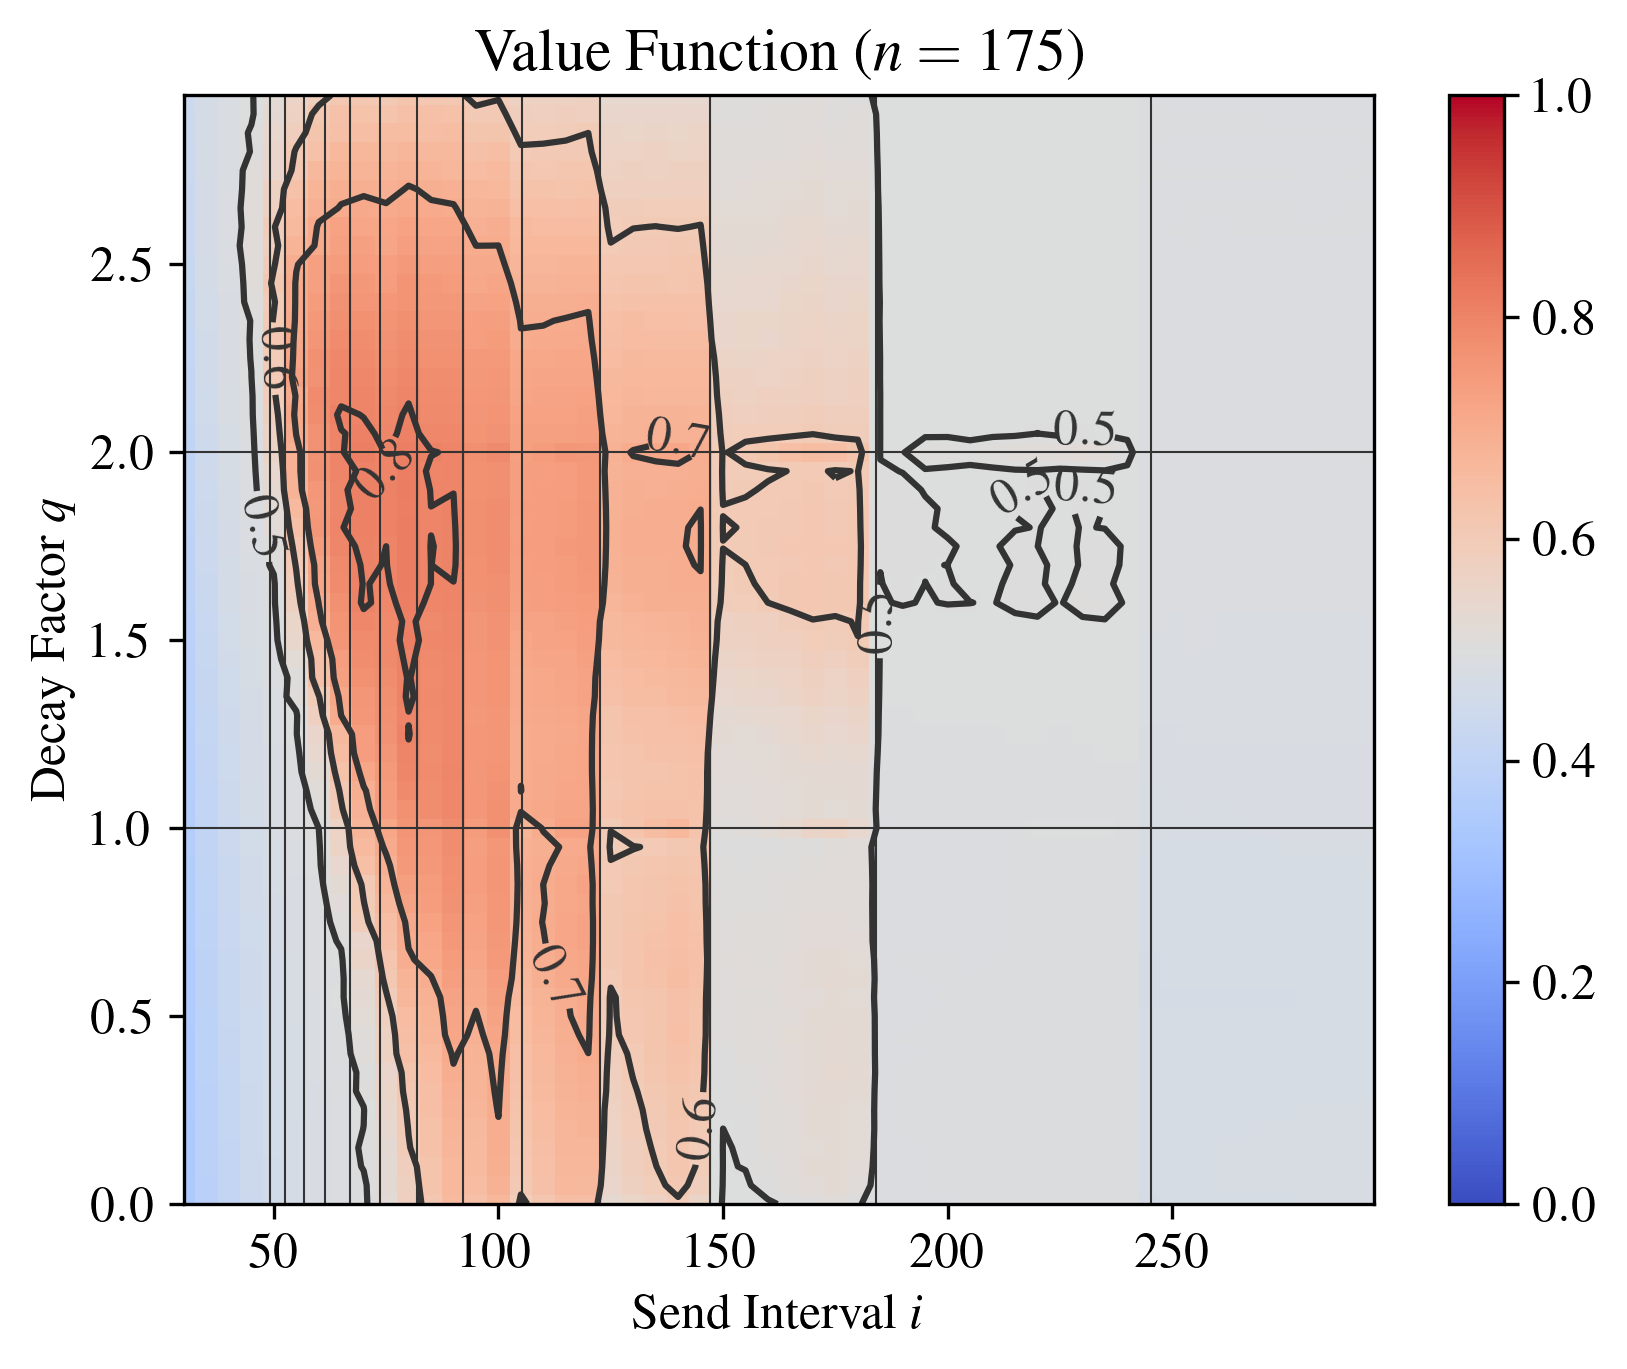

In [5]:
fig, ax = plt.subplots()
# ax.plot([0],[0])
ax.set_ylim([0, 2.95])
ax.set_xlim([30, 295])

gs = 30

X = df['i'].to_numpy()
Y = df['q'].to_numpy() / 100
C = df['reward'].to_numpy()

# pcm = ax.hexbin(
#         X, 
#         Y,
#         C=C, 
#         vmin=0,
#         vmax=1,
#         cmap=cm.coolwarm,
#         gridsize=gs,
#         extent=(30, 295, 0, 1.95)
#     )
# ax.contour([X,Y], C, levels=np.arange(0.1, 0.9, 0.1))

for f in range(3, 16):
    ax.plot([aoi_target / f, aoi_target / f], [0, 200], color='#333', lw = 0.5)


ax.plot([0, 300], [1, 1], color='#333', lw = 0.5)
ax.plot([0, 300], [2, 2], color='#333', lw = 0.5)


step = 5
i_bins = list(np.arange(30-step/2, 300+step/2, step))
q_bins = list(np.arange(0-step/2, 300+step/2, step) / 100)
i_pos = list(np.arange(30, 300, step))
q_pos = list(np.arange(0, 300, step) / 100)
ret = scipy.stats.binned_statistic_2d(X, Y, C, 'mean', bins=[i_bins,q_bins])
cntr = ax.contour(i_pos, q_pos, np.swapaxes(ret.statistic, axis1=0, axis2=1), [0.5, 0.6, 0.7, 0.8, 0.9], colors='#333')
#cmap=cm.gray, vmin=0.5, vmax=0.9
ax.clabel(cntr, [0.5, 0.6, 0.7, 0.8, 0.9])
pcm = ax.pcolormesh(
    i_pos, 
    q_pos, 
    np.swapaxes(ret.statistic, axis1=0, axis2=1), 
    vmin=0,
    vmax=1,
    cmap=cm.coolwarm,
    linewidth=0,
    rasterized=True
)
fig.colorbar(pcm, ax=ax)


# ax.set_xscale('log')
# ax.set_xticks([aoi_target / 3, aoi_target / 4, aoi_target / 5, aoi_target / 6, aoi_target / 7, aoi_target / 8, aoi_target / 9])
# ax.set_xticklabels(['$i_0/3$', '$i_0/4$', '$i_0/5$', '$i_0/6$', '$i_0/7$', '$i_0/8$', '$i_0/9$'])


ax.set_ylabel('Decay Factor $q$')
ax.set_xlabel('Send Interval $i$')
plt.title(f'Value Function ($n={n}$)')

fig.savefig(f"../figures/value_function_n{n}_v2.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/value_function_n{n}_v2.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
# ax.grid()

plt.show()

In [6]:
# step = 5
# i_bins = list(np.arange(30-step/2, 300+step/2, step))
# q_bins = list(np.arange(0-step/2, 200+step/2, step) / 100)
# i_pos = list(np.arange(30, 300, step))
# q_pos = list(np.arange(0, 200, step) / 100)
# ret = scipy.stats.binned_statistic_2d(X, Y, C, 'mean', bins=[i_bins,q_bins])
# plt.contour(i_pos, q_pos, np.swapaxes(ret.statistic, axis1=0, axis2=1), [0.5],colors='#333')
#plt.imshow(ret.statistic, cmap=cm.coolwarm,  vmin=0, vmax=1, interpolation='nearest')
# plt.contour([len(ret.statistic), len(ret.statistic[0])], ret.statistic, [0.5, 0.75, 1])
# plt.show()

# plt.pcolor(i_pos, q_pos, np.swapaxes(ret.statistic, axis1=0, axis2=1))